In [1]:
from datetime import datetime
import json
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

from lib.util import load_json

GEOGRAPHY_PATH = os.environ.get('GEOGRAPHY_PATH', '../datasets/geography.json')
AGGREGATE_PATH = os.environ.get('AGGREGATED_DATA_PATH', '../artifacts/aggregate.json')
CATEGORIZED_PATH = os.environ.get('CATEGORIZED_PATH', '../artifacts/categorized.json')

region_definitions = load_json(GEOGRAPHY_PATH)
df = pd.read_json(AGGREGATE_PATH)
categorized = load_json(CATEGORIZED_PATH)

regions, state_regions = itemgetter('regions', 'state_regions')(region_definitions)

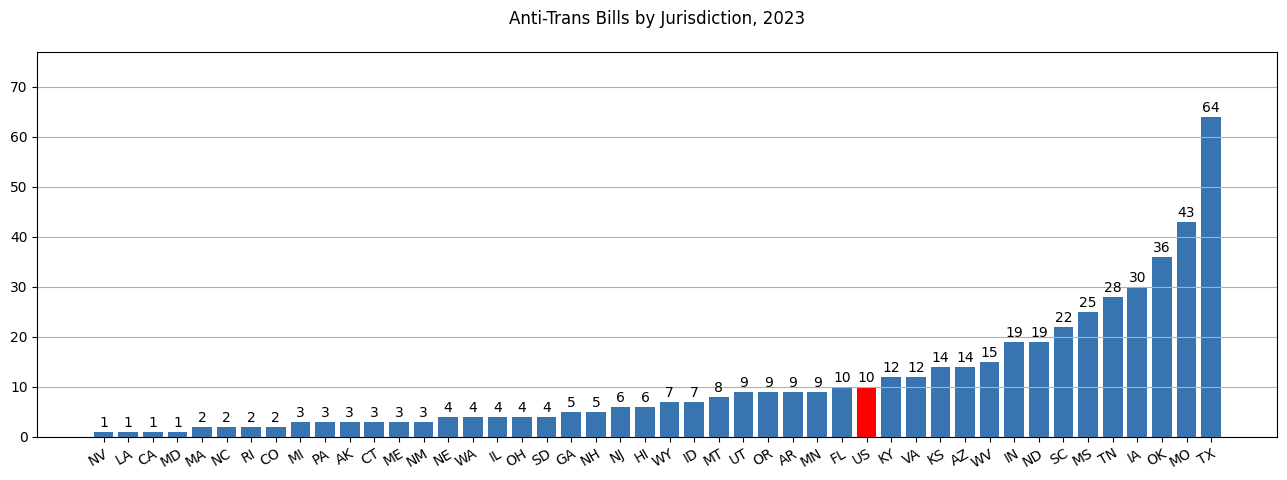

In [2]:
data = df['state'].value_counts().sort_values()
bar_colors = ['red' if location == 'US' else (0.22,0.46,0.69) for location in data.index]

y_pos = np.arange(len(data))
plt.figure(figsize=(16,5))
plt.ylim(0, round(1.2*data.max(), 0))
plt.xticks(y_pos, data.index, rotation=30, ha="right", rotation_mode="anchor")
plt.grid(True, which='major', axis='y')
# plt.bar(y_pos, data, align='center', width=0.8)
plt.bar(y_pos, data, align='center', width=0.8, color=bar_colors)
for i in range(len(data)):
    plt.text(i,data.iloc[i] + 1,data.iloc[i], ha='center')
plt.title('Anti-Trans Bills by Jurisdiction, 2023', pad=20)
plt.show()

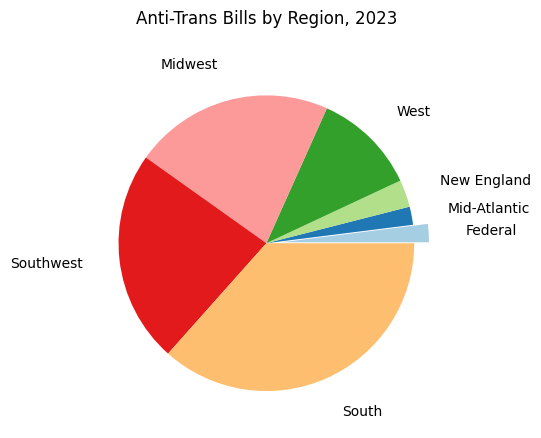

In [3]:
data = (
    df.copy()
        .rename(columns={'state': 'region'})
        ['region']
        .transform(lambda x: state_regions[x])
        .value_counts()
        .sort_values()
)

radii = [0.1 if region == 'Federal' else 0 for region in data.index.tolist()]

colors = sns.color_palette('Paired')
plt.pie(data, labels=data.index, explode=radii, colors=colors, labeldistance=1.25)
plt.title('Anti-Trans Bills by Region, 2023', pad=25)
plt.show()

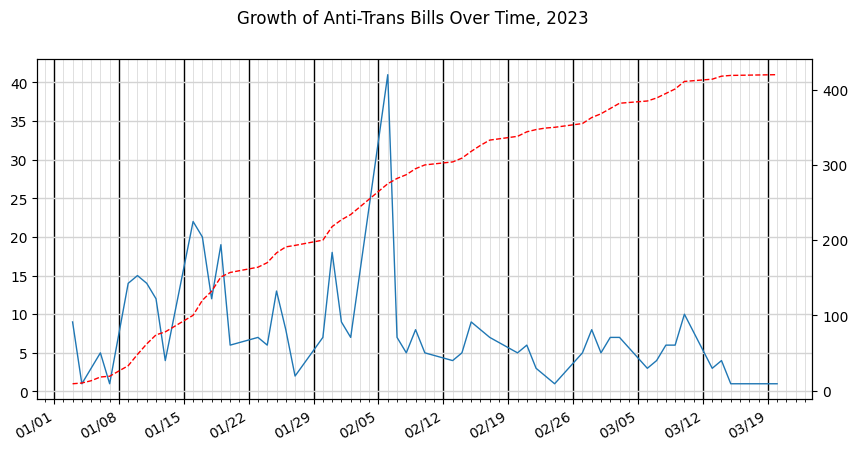

In [8]:
data = (
    df
        .loc[df.introduced_date != '']
        .loc[df.introduced_date >= '2022/09/01']
        .copy()
        ['introduced_date'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
        .value_counts()
        .sort_index()
)

data2 = data.cumsum()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('Growth of Anti-Trans Bills Over Time, 2023')

week_locator = mdates.WeekdayLocator(byweekday=6,interval=1)
day_locator = mdates.DayLocator(interval=1)
week_formatter = mdates.DateFormatter("%m/%d")
day_formatter = mdates.DateFormatter("%a")

ax.xaxis.set_major_locator(week_locator)
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(week_formatter)

ax.grid(True, which='major', axis='x', color='black', linewidth=1)
ax.grid(True, which='minor', axis='x', color='lightgray', linewidth=0.5)
ax.grid(True, which='major', axis='y', color='lightgray', linewidth=1)

ax2=ax.twinx()

ax.plot(data, linewidth=1)
ax2.plot(data2, 'r--', linewidth=1)

fig.autofmt_xdate(rotation=30)

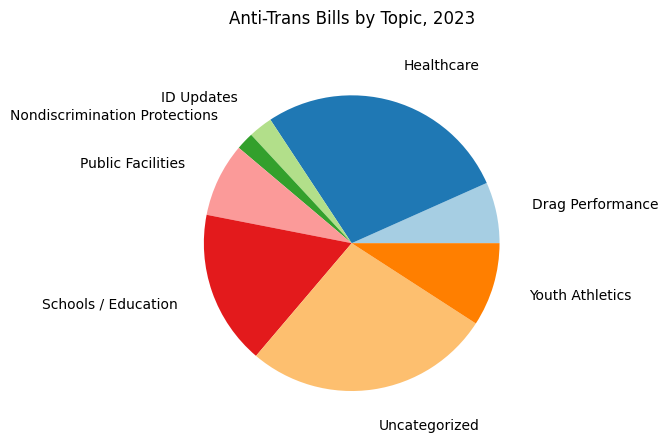

In [5]:
categorized_series = pd.DataFrame.from_dict(
    data={
        k: len(v)
        for k, v
        in categorized.items()
        if len(v) > 0
    },
    orient='index',
    columns=['ct'],
)['ct'].sort_index()

colors = sns.color_palette('Paired')
plt.pie(categorized_series, labels=categorized_series.index, colors=colors, labeldistance=1.25)
plt.title('Anti-Trans Bills by Topic, 2023', pad=25)
plt.show()